(sec-ray-tune)=
# Ray Tune

Ray Tune 主要面向超参数调优场景，将模型训练、超参数选择和并行计算结合起来，它底层基于 Ray 的 Actor、Task 和 Ray Train，并行地启动多个机器学习训练任务，并选择最好的超参数。Ray Tune 适配了 PyTorch、Keras、XGBoost 等常见机器学习训练框架，提供了常见超参数调优算法（例如随机搜索、贝叶斯优化等）和工具（[BayesianOptimization](https://github.com/bayesian-optimization/BayesianOptimization)、[Optuna](https://github.com/optuna/optuna)等）。用户可以基于 Ray Tune 在 Ray 集群上进行批量超参数调优。

## 超参数调优

{numref}`sec-machine-learning-intro` 中我们提到了模型的参数和超参数（Hyperparameter）的概念。超参数指的是模型参数（权重）之外的一些参数，比如深度学习模型训练时控制梯度下降速度的学习率，又比如决策树中分支的数量。超参数通常有两类：

* 模型：神经网络的设计，比如多少层，卷积神经网络的核大小，决策树的分支数量等。
* 训练和算法：学习率、批量大小等。

确定这些超参数的方式是开启多个试验（Trial），每个试验测试超参数的某个值，根据模型训练结果的好坏来做选择，这个过程称为超参数调优。寻找最优超参数的过程这个过程可以手动进行，手动的话费时费力，效率低下，所以业界提出一些自动化的方法。常见的自动化的搜索方法有：

* 网格搜索（Grid Search）：网格搜索是一种穷举搜索方法，它通过遍历所有可能的超参数组合来寻找最优解，这些组合会逐一被用来训练和评估模型。网格搜索简单直观，但当超参数空间很大时，所需的计算成本会急剧增加。
* 随机搜索（Random Search）：随机搜索不是遍历所有可能的组合，而是在解空间中随机选择超参数组合进行评估。这种方法的效率通常高于网格搜索，因为它不需要评估所有可能的组合，而是通过随机抽样来探索参数空间。随机搜索尤其适用于超参数空间非常大或维度很高的情况下，它可以在较少的尝试中发现性能良好的超参数配置。然而，由于随机性的存在，随机搜索可能会错过一些局部最优解，因此可能需要更多的尝试次数来确保找到一个好的解。
* 贝叶斯优化（Bayesian Optimization）：贝叶斯优化是一种基于贝叶斯定理的技术，它利用概率模型来指导搜索最优超参数的过程。这种方法的核心思想是构建一个贝叶斯模型，通常是高斯过程（Gaussian Process），来近似评估目标函数的未知部分。贝叶斯优化能够在有限的评估次数内，智能地选择最有希望的超参数组合进行尝试，特别适用于计算成本高昂的场景。

## 关键组件

Ray Tune 主要包括以下组件：

* 将原有的训练过程抽象为一个可训练的函数（Trainable）
* 定义需要搜索的超参数搜索空间（Search Space）
* 使用一些搜索算法（Search Algorithm）和调度器（Scheduler）并行训练和智能调度。

{numref}`fig-ray-tune-key-parts` 展示了适配 Ray Tune 的关键部分。用户创建一个 [`Tuner`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.Tuner.html)，`Tuner` 中包含了需要训练的 Trainable 函数、超参数搜索空间，用户选择搜索算法或者使用某种调度器。不同超参数组合组成了不同的试验，Ray Tune 根据用户所申请的资源和集群已有资源，并行训练。用户可对多个试验的结果进行分析。

```{figure} ../img/ch-ray-train-tune/ray-tune-key-parts.svg
---
width: 500px
name: fig-ray-tune-key-parts
---
Ray Tune 关键部分
```

## Trainable

跟其他超参数优化库一样，Ray Tune 需要一个优化目标（Objective），它是 Ray Tune 试图优化的方向，一般是一些机器学习训练指标，比如模型预测的准确度等。Ray Tune 用户需要将优化目标封装在可训练（Trainable）函数中，可在原有单节点机器学习训练的代码上进行改造。Trainable 函数接收一个字典式的配置，字典中的键是需要搜索的超参数。在 Trainable 函数中，优化目标以 `ray.train.report(...)` 方式存储起来，或者作为 Trainable 函数的返回值直接返回。例如，如果用户想对超参数 `lr` 进行调优，优化目标为 `score`，除了必要的训练代码外，Trainable 函数如下所示：

```python
def trainable(config):
    lr = config["lr"]
    
    # 训练代码 ...
    
    # 以 ray.train.report 方式返回优化目标
    ray.train.report({"score": ...})
    # 或者使用 return 或 yield 直接返回
    return {"score": ...}
```

对图像分类案例进行改造，对 `lr` 和 `momentum` 两个超参数进行搜索，Trainable 函数是代码中的 `train_mnist()`：

In [2]:
import os
import tempfile

import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.models import resnet18

from ray import tune
from ray.tune.schedulers import ASHAScheduler

import ray
import ray.train.torch
from ray.train import Checkpoint

In [3]:
data_dir = os.path.join(os.getcwd(), "../data")

def train_func(model, optimizer, criterion, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

def train_mnist(config):
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(), 
         torchvision.transforms.Normalize((0.5,), (0.5,))]
    )

    train_loader = DataLoader(
        torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform),
        batch_size=128,
        shuffle=True)
    test_loader = DataLoader(
        torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform),
        batch_size=128,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = resnet18(num_classes=10)
    model.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    
    # 训练 10 个 epoch
    for epoch in range(10):
        train_func(model, optimizer, criterion, train_loader)
        acc = test_func(model, test_loader)

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (epoch + 1) % 5 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            ray.train.report({"mean_accuracy": acc}, checkpoint=checkpoint)

## 搜索空间

搜索空间是超参数可能的值，Ray Tune 提供了一些方法定义搜索空间。比如，[`ray.tune.choice()`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.sample_from.html) 从某个范围中选择可能的值，[`ray.tune.uniform()`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.uniform.html) 从均匀分布中选择可能的值。现在对 `lr` 和 `momentum` 两个超参数设置搜索空间：

In [4]:
search_space = {
    "lr": tune.choice([0.001, 0.002, 0.005, 0.01, 0.02, 0.05]),
    "momentum": tune.uniform(0.1, 0.9),
}

## 搜索算法和调度器

Ray Tune 内置了一些搜索算法或者集成了常用的包，比如 [BayesianOptimization](https://github.com/bayesian-optimization/BayesianOptimization)、[Optuna](https://github.com/optuna/optuna) 等，比如贝叶斯优化等。如果不做设置，默认使用随机搜索。

我们先使用随机搜索：

In [5]:
trainable_with_gpu = tune.with_resources(train_mnist, {"gpu": 1})

tuner = tune.Tuner(
    trainable_with_gpu,
    param_space=search_space,
)
results = tuner.fit()

(train_mnist pid=41485) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-20-25/train_mnist_421ef_00000_0_lr=0.0020,momentum=0.2905_2024-04-11_21-20-26/checkpoint_000000)
(train_mnist pid=41485) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-20-25/train_mnist_421ef_00000_0_lr=0.0020,momentum=0.2905_2024-04-11_21-20-26/checkpoint_000001)
2024-04-11 21:24:22,692	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHE

调度器会对每个试验进行分析，未训练完就提前结束某个试验，提前结束又被称为早停（Early Stopping），这样可以节省计算资源，把计算资源留给最有希望的某个试验。下面的例子使用了 [ASHA 算法](https://openreview.net/forum?id=S1Y7OOlRZ) {cite}`li2018Massively` 进行调度。

前面例子中，没设置 [`ray.tune.TuneConfig`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.TuneConfig.html)，默认只进行了一次试验。现在我们设置 `ray.tune.TuneConfig` 中的 `num_samples`，该参数表示希望进行多少次试验。同时使用 [ray.tune.schedulers.ASHAScheduler](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.schedulers.ASHAScheduler.html) 来做选择，提前结束那些性能较差的试验，把计算结果留给更有希望的试验。`ASHAScheduler` 的参数 `metric` 和 `mode` 表示希望优化的目标，本例的目标是最大化 "mean_accuracy"。

In [6]:
tuner = tune.Tuner(
    trainable_with_gpu,
    tune_config=tune.TuneConfig(
        num_samples=16,
        scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    ),
    param_space=search_space,
)
results = tuner.fit()

(train_mnist pid=41806) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-24-22/train_mnist_cf61b_00002_2_lr=0.0020,momentum=0.4789_2024-04-11_21-24-22/checkpoint_000000)
(train_mnist pid=42212) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-24-22/train_mnist_cf61b_00005_5_lr=0.0050,momentum=0.8187_2024-04-11_21-24-22/checkpoint_000000) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(train_mnist pid=41806) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-24-22/train_mnist_cf61b_00002_2_lr=0.0020,momentum=0.4789_2024-04-11_21-24-22/checkpoint_000001)
(train_mnist pid=41809) Checkpoint succes

2024-04-11 21:34:30,051	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-11 21:34:30,067	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/u20200002/ray_results/train_mnist_2024-04-11_21-24-22' in 0.0224s.
2024-04-11 21:34:30,083	INFO tune.py:1048 -- Total run time: 607.32 seconds (607.25 seconds for the tuning loop).


屏幕上会打印出每个试验所选择的超参数值和目标，对于性能较差的试验，简单迭代几轮（`iter`）之后就早停了。我们对这些试验的结果进行可视化：

Text(0, 0.5, 'Mean Accuracy')

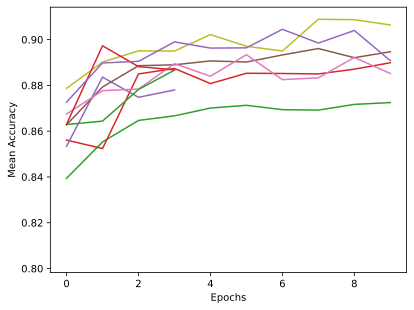

In [7]:
%config InlineBackend.figure_format = 'svg'

dfs = {result.path: result.metrics_dataframe for result in results}
ax = None
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Accuracy")

以上为 Ray Tune 的完整案例，接下来我们介绍搜索算法和调度器。